## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import itertools

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split


# Data Reading/Data Understanding



In [3]:
import pandas as pd
data = pd.read_json('complaints.json')
data.head()

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."


In [4]:
# Converting .
data_1=pd.Series.to_dict(data['_source'])
data_2=pd.DataFrame(data_1)
data_3=data_2.T
data_4=data.drop(['_source'],axis=1)
df=pd.concat([data_4,data_3],axis=1)
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# Inspect the dataframe to understand the given data.

df.head(10)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [13]:
#Checking the statistics 
df.describe()

,_id,_score
count,7.831300e+04,78313.0
mean,2.094270e+06,0.0
std,1.277635e+06,0.0
min,4.100000e+01,0.0
25%,9.137850e+05,0.0
50%,2.216370e+06,0.0
75%,3.165904e+06,0.0
max,4.366257e+06,0.0


In [12]:
#checking the shape of the dataset
df.shape

(78313, 22)

In [11]:
#Checking the size of the dataset
df.size

1722886

In [9]:
#Checking the length of the dataset
len(df)

78313

In [8]:
#Checking the presence of any duplicated rows.
df.duplicated() 

0        False
1        False
2        False
3        False
4        False
         ...  
78308    False
78309    False
78310    False
78311    False
78312    False
Length: 78313, dtype: bool

In [14]:
df.isnull().sum()

_index                           0
_type                            0
_id                              0
_score                           0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

# Data preparation/Cleaning

In [19]:
#Assign new column names
#df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns=lambda x: x.strip('_'), inplace=True)

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [20]:
#Create a Copy for Exploratory Data Analysis

df_eda = df.copy(deep=True)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      78313 non-null  object
 1   type                       78313 non-null  object
 2   id                         78313 non-null  int64 
 3   score                      78313 non-null  int64 
 4   tags                       10900 non-null  object
 5   zip_code                   71556 non-null  object
 6   complaint_id               78313 non-null  object
 7   issue                      78313 non-null  object
 8   date_received              78313 non-null  object
 9   state                      76322 non-null  object
 10  consumer_disputed          78313 non-null  object
 11  product                    78313 non-null  object
 12  company_response           78313 non-null  object
 13  company                    78313 non-null  object
 14  submit

In [21]:
df_eda.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [22]:
#Assign nan in place of blanks in the complaints column
df_eda['complaint_what_happened'] = np.where(df_eda['complaint_what_happened'] =='', np.nan, df_eda['complaint_what_happened'])
df_eda['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [23]:
cleaned_rows = df_eda['complaint_what_happened'].isna().sum()
ratio = round((cleaned_rows/len(df_eda))*100,2)
print ("{} rows has been cleaned from the original {} rows, which is  {}% of the dataset".format(cleaned_rows, len(df_eda), ratio))

57241 rows has been cleaned from the original 78313 rows, which is  73.09% of the dataset


In [24]:
#Remove all rows where complaints column is nan
df_eda= df_eda[~df_eda.complaint_what_happened.isna()]
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      21072 non-null  object
 1   type                       21072 non-null  object
 2   id                         21072 non-null  int64 
 3   score                      21072 non-null  int64 
 4   tags                       3816 non-null   object
 5   zip_code                   16427 non-null  object
 6   complaint_id               21072 non-null  object
 7   issue                      21072 non-null  object
 8   date_received              21072 non-null  object
 9   state                      20929 non-null  object
 10  consumer_disputed          21072 non-null  object
 11  product                    21072 non-null  object
 12  company_response           21072 non-null  object
 13  company                    21072 non-null  object
 14  submit

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [25]:
#Lets first find patterns which we need to remove

brackets = df_eda[df_eda.complaint_what_happened.str.contains('\[\s*\w*\s*\]')]
print("No of complaints with brackets = {}".format(len(brackets)))

No of complaints with brackets = 87


In [26]:
brackets = df_eda[df_eda.complaint_what_happened.str.contains('\S*\d\S*')]
print("No of complaints with words having numbers = {}".format(len(brackets)))

No of complaints with words having numbers = 16494


In [27]:
df_eda.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [28]:
## Write your function here to Clean the text and remove all the unnecessary elements.
def clean_text(text):
   text = text.lower()
   text = re.sub("\[\s*\w*\s*\]", "", text)
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = re.sub("\S*\d\S*", "", text)

   return text

df_eda.complaint_what_happened = pd.DataFrame(df_eda.complaint_what_happened.apply(lambda x: clean_text(x)))  

In [29]:
pd.set_option('display.max_colwidth', None)
df_eda.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA

# Data Preprocessing/Data Visualisation

In [30]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

In [31]:
## Using nlp pipes with chunking for faster execution 
def pos_lemmatize_pipe(doc):
    document_lemma = " ".join([tok.lemma_ for tok in doc])
    document_pos = " ".join([tok.text for tok in doc if tok.pos_ == 'NOUN']) 
    return document_lemma, document_pos

def spacy_pos_lemmatizer(texts):
    return [pos_lemmatize_pipe(doc) for doc in nlp.pipe(texts, batch_size=40, disable=["tok2vec", "parser", "ner"])]
    
df_eda['complaints_lemma'],  df_eda['complaints_pos_tags'] = zip(*spacy_pos_lemmatizer(df_eda.complaint_what_happened))

In [32]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_eda[['complaint_what_happened', 'complaints_lemma','complaints_pos_tags']].copy()

In [33]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account

In [34]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaints_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




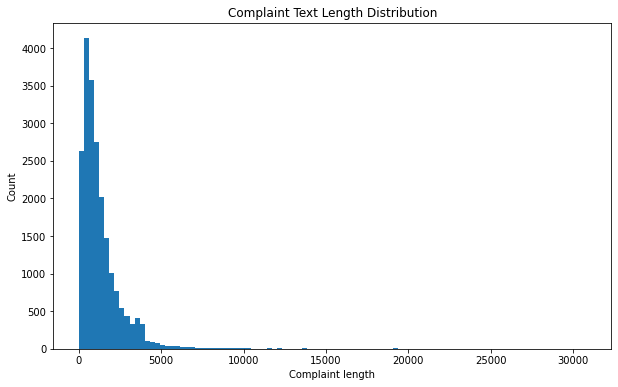

In [35]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len'] = df_clean['complaint_what_happened'].astype(str).apply(len)

plt.figure(figsize=(10,6))
df_clean['complaint_len'].plot.hist(bins=100, title='Complaint Text Length Distribution')
plt.xlabel('Complaint length')
plt.ylabel('Count')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

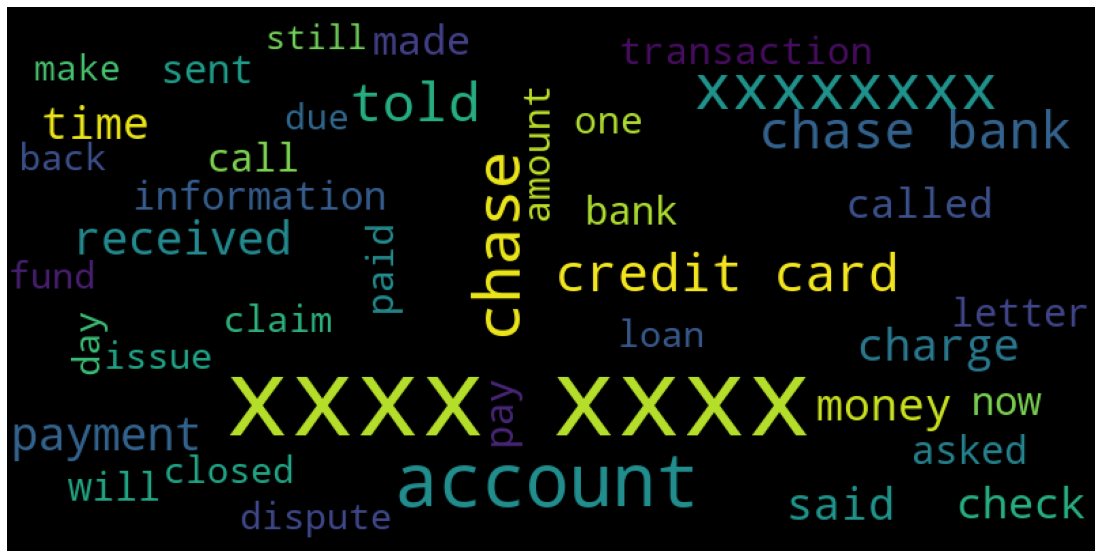

In [36]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)
wordcloud.generate(" ".join(df_clean['complaint_what_happened']))
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [37]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaints_lemma'].str.replace('-PRON-', '')

In [38]:
#All -PRON- texts has been removed 
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,475,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,210,chase car

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [39]:
#Function to return the top 'n' words from corpus for a given 'n_gram_range'
def get_top_n_ngram( corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

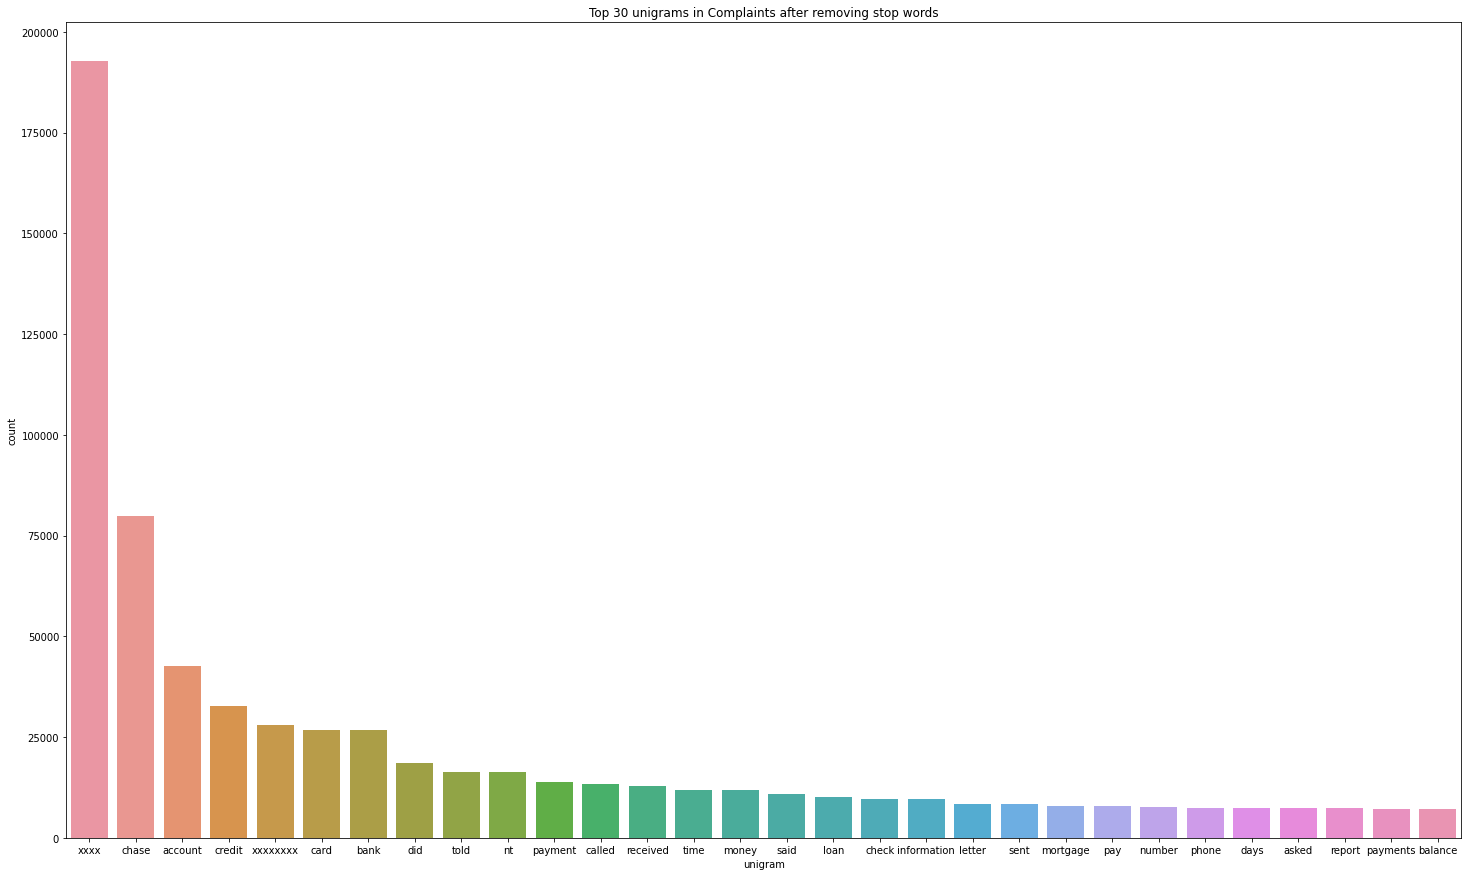

In [40]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 1, 30)
df1 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=[25,15])
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.title('Top 30 unigrams in Complaints after removing stop words')
plt.show()

In [41]:
#Print the top 10 words in the unigram frequency
#The top 10 words in the unigram frequency
df1.head(10)

,unigram,count
0,xxxx,192695
1,chase,79861
2,account,42591
3,credit,32677
4,xxxxxxxx,27927
5,card,26847
6,bank,26651
7,did,18481
8,told,16380
9,nt,16289


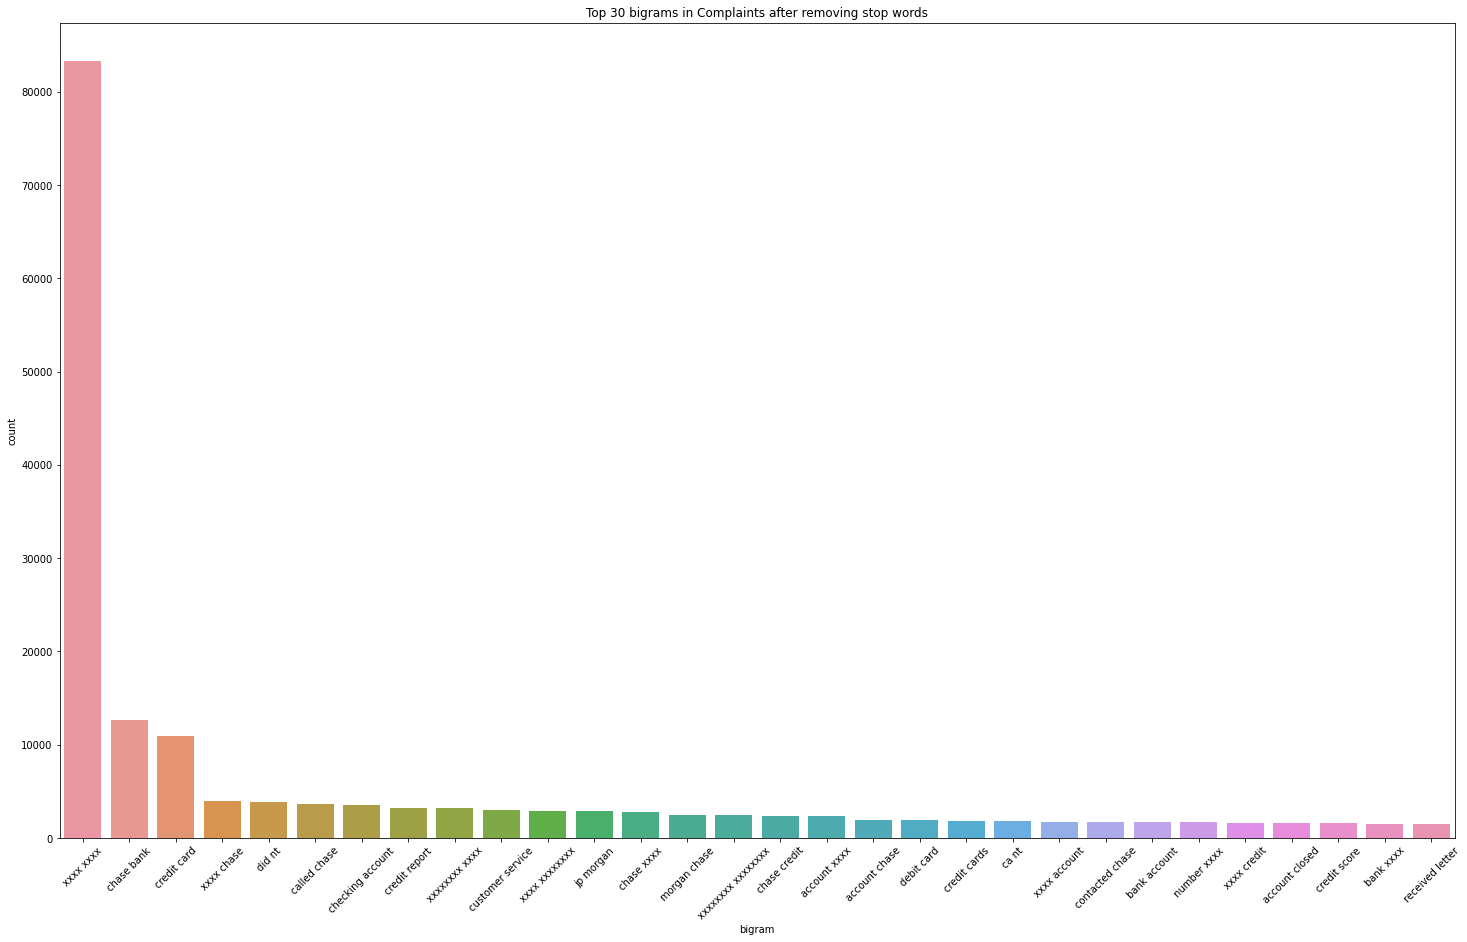

In [42]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 2, 30)
df2 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.title('Top 30 bigrams in Complaints after removing stop words')
plt.show()

In [43]:
#Print the top 10 words in the bigram frequency
df2.head(10)

,bigram,count
0,xxxx xxxx,83247
1,chase bank,12609
2,credit card,10905
3,xxxx chase,3945
4,did nt,3837
5,called chase,3688
6,checking account,3551
7,credit report,3237
8,xxxxxxxx xxxx,3206
9,customer service,3014


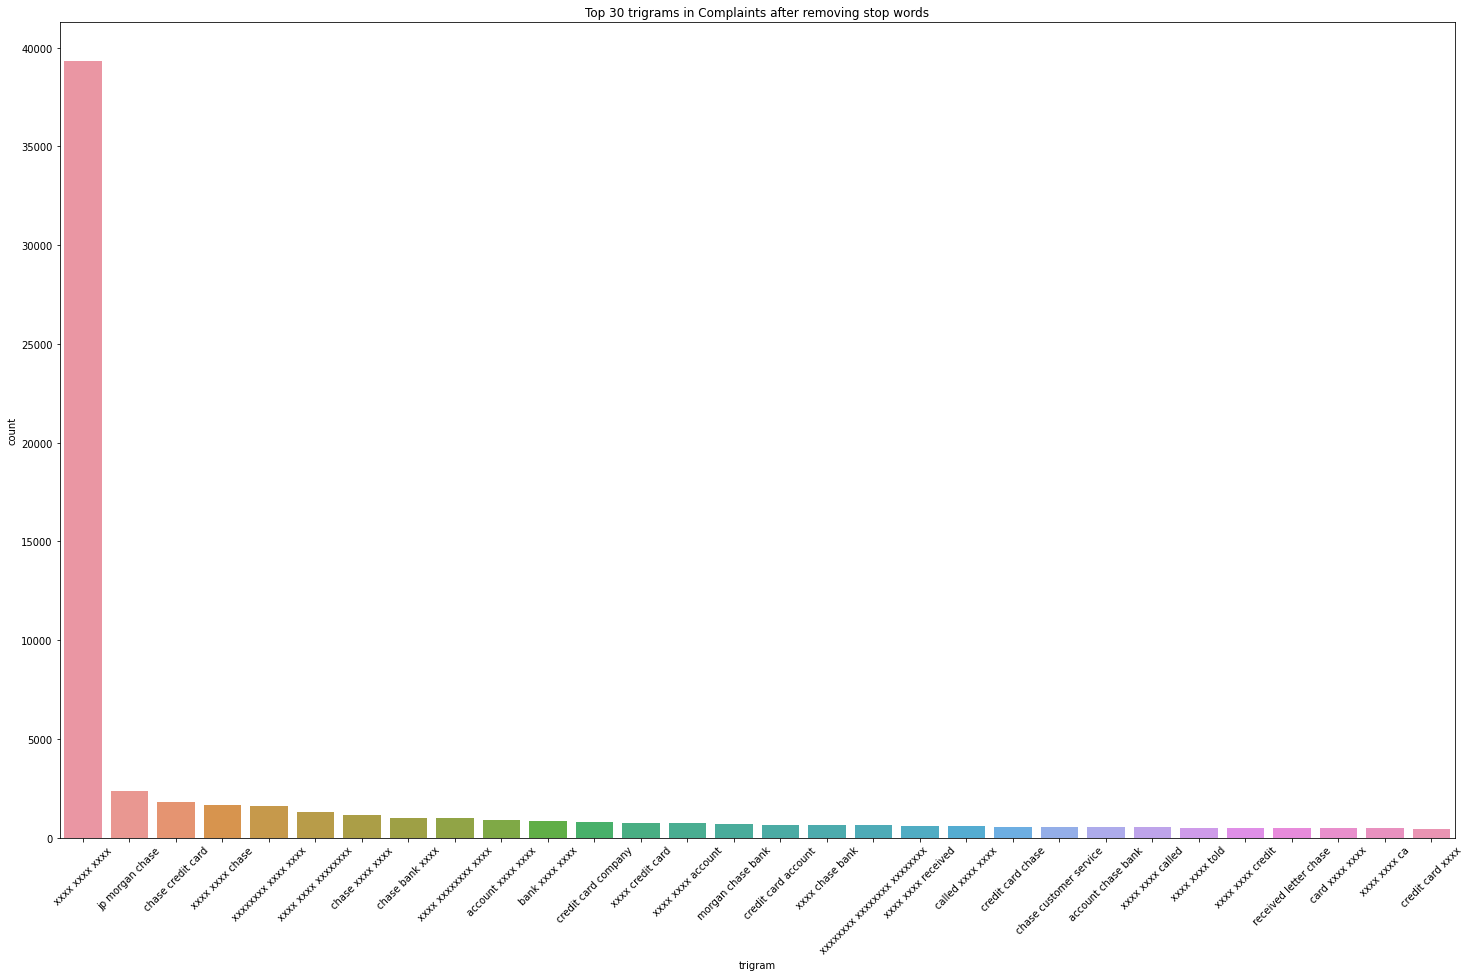

In [44]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 3, 30)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.title('Top 30 trigrams in Complaints after removing stop words')
plt.show()

In [45]:
#Print the top 10 words in the trigram frequency
df3.head(10)

,trigram,count
0,xxxx xxxx xxxx,39319
1,jp morgan chase,2340
2,chase credit card,1810
3,xxxx xxxx chase,1658
4,xxxxxxxx xxxx xxxx,1594
5,xxxx xxxx xxxxxxxx,1293
6,chase xxxx xxxx,1151
7,chase bank xxxx,984
8,xxxx xxxxxxxx xxxx,969
9,account xxxx xxxx,913


##  xxxx has been used to mask the personal details of the customers.We will drop these masked details as they will be indisignificant for our study

In [46]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [47]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,475,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,210,chase card was reported on however fraudulent application have been submitted

# Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [48]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.90)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [49]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [50]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [51]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [52]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

C:\Users\44775\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

C:\Users\44775\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



9430

In [53]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words  

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,card,chase,charges,charge,dispute,did,called,fraud,received,told,claim,merchant,transaction,nt,said
Topic 1,credit,card,report,inquiry,chase,cards,hard,inquiries,reporting,score,accounts,account,closed,debt,removed
Topic 2,loan,mortgage,chase,home,modification,property,payments,foreclosure,house,years,bank,jp,morgan,sale,rate
Topic 3,account,bank,check,chase,money,funds,checking,closed,deposit,nt,branch,told,accounts,deposited,said
Topic 4,payment,late,payments,balance,paid,pay,fee,fees,month,statement,charged,account,chase,monthly,make


#### `Topic 0` looks to be `Bank account services`
#### `Topic 1` looks to be `Credit card / Prepaid card`
#### `Topic 2` looks to be `Mortgages/loans`
#### `Topic 3` looks to be `Theft/Dispute reporting`
#### `Topic 4` looks to be `Others`

In [54]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic {}".format(i) for i in range(nmf_model.n_components)]
complaintnames = ["Complaint{}".format(i) for i in range(len(df_clean.index))]
df_doc_topic = pd.DataFrame(W, columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_id'] = significant_topic

In [55]:
df_doc_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Complaint0,0.007963,0.011416,0.026066,0.021591,0.005040,2
Complaint1,0.012091,0.005230,0.001707,0.005712,0.003101,0
Complaint2,0.009583,0.042775,0.000445,0.000000,0.000000,1
Complaint3,0.022047,0.047137,0.017146,0.017567,0.000000,1
Complaint4,0.002546,0.000000,0.003243,0.065850,0.000259,3
...,...,...,...,...,...,...
Complaint21067,0.019287,0.058318,0.000000,0.000000,0.022496,1
Complaint21068,0.048819,0.002967,0.004029,0.002700,0.001254,0
Complaint21069,0.024014,0.007712,0.007063,0.016052,0.000000,0
Complaint21070,0.020662,0.027382,0.004317,0.000006,0.089203,4


In [56]:
# Here we are assigning topic starting from 0, 1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)], index=[f'Complaint{i}' for i in range(W.shape[0])])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
Complaint0,0.007963,0.011416,0.026066,0.021591,0.005040,Topic 2
Complaint1,0.012091,0.005230,0.001707,0.005712,0.003101,Topic 0
Complaint2,0.009583,0.042775,0.000445,0.000000,0.000000,Topic 1
Complaint3,0.022047,0.047137,0.017146,0.017567,0.000000,Topic 1
Complaint4,0.002546,0.000000,0.003243,0.065850,0.000259,Topic 3
Complaint5,0.000000,0.041635,0.000000,0.000000,0.000000,Topic 1
Complaint6,0.001837,0.000241,0.009165,0.060467,0.017170,Topic 3
Complaint7,0.013155,0.000000,0.033182,0.000000,0.043020,Topic 4
Complaint8,0.057353,0.000000,0.010895,0.016569,0.000224,Topic 0
Complaint9,0.005128,0.093006,0.000000,0.000000,0.000000,Topic 1


In [57]:
#Assign the best topic to each of the cOmplaints in Topic Column

df_clean['Topic'] = W.max_topic.values

In [58]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,475,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account thanks in advance for your help,2,Topic 2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0,Topic 0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,210,chase card was reported on however fraudul

In [59]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0,Topic 0
21,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient that xxxx my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team i called the number listed in the email and explained my situation to then be transferred to the claims department i was directed to call xxxx and ask them about the transaction because chase did not have any information outside of what i provided when initiating the transfer i felt like this agent was trying to get me to end the call as quickly as possible and i had to interrupt her closing script to ask for a contact number at xxxx and didnt have an opportunity to get any information about what the right questions would be to ask xxxx or what words and phrases i should use to get the information i was looking for \n\ni called xxxx whos automated system initially directed me to call my bank because i used the banks app to initiate the transaction i called xxxx again to navigate their menus and talk to a customer service agent they told me that all of the information about the transaction would in chase s system because i used the banks app to perform the transaction she stayed on the line with me until i understood everything that i should ask and had a better understanding of the situation i ended the call and called chase again \n\nwhen i called chase the second time the agent tried to look up the information about the receiving bank but could not find any additional information she then asked me why i needed this information and i explained my situation again i was once again transferred to the claims department who told me that i needed to contact xxxx to get the information i was looking for after i told her that i had already contacted them she finally admitted that there was nothing 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [60]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    'Topic 0': 'Bank Account_Services',
    'Topic 1': 'Credit_card or Prepaid_card',
    'Topic 2': 'Mortgage/loan',
    'Topic 3': 'Theft/Dispute Reporting',
    'Topic 4': 'Others'   
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [61]:
df_clean.head()

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,475,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account thanks in advance for your help,2,Mortgage/loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0,Bank Account_Services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,210,chase card was reporte

# Model Building

In [62]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [63]:
df_clean

,complaint_what_happened,complaints_lemma,complaints_pos_tags,complaint_len,complaint_clean,topic_id,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,475,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \n in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \n i have a right to know this information as a consumer \n\n chase account thanks in advance for your help,2,NaN
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,337,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0,NaN
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,210,chase card was reported on however fraudulent appl

In [64]:
#Keep the columns"complaint_what_happened" & "topic_id" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'topic_id']]

In [65]:
training_data.head()

,complaint_what_happened,topic_id
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,2
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [66]:
# Split into train, validation 80%,20% respectively
X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaint_what_happened, training_data.topic_id , train_size=0.8, random_state=40)

In [67]:
#Get the Vector count
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Transform the word vector to tf-idf
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [68]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16857, 30014) (16857,)
(4215, 30014) (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [79]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# This function plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [80]:
## For y_true and y_pred display the Classification Metrics and plot Confusion Matrix
def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            # Plot non-normalized confusion matrix
            class_names = [0,1,2,3,4]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix
                      , classes=class_names)                      
            plt.show()

In [81]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    #Predict validation set:
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test_data, y_test_pred, plot)

In [105]:
#Roc Curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
import yellowbrick.classifier
from yellowbrick.classifier import ROCAUC


def plot_ROC_curve(alg, X_train_data, y_train_data, X_test_data, y_test_data):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(alg, encoder={0: 'Bank Account_Services', 
                                      1: 'Credit_card or Prepaid_card', 
                                      2: 'Mortgage/loan', 
                                      3: 'Theft/Dispute Reporting', 
                                      4: 'Other'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train_data, y_train_data)
    visualizer.score(X_test_data, y_test_data)
    visualizer.show()
    
    return visualizer

In [102]:
#Using Decision Trees
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       923
           1       0.80      0.77      0.78       888
           2       0.89      0.73      0.81       757
           3       0.79      0.82      0.80      1098
           4       0.78      0.64      0.70       549

    accuracy                           0.76      4215
   macro avg       0.78      0.75      0.76      4215
weighted avg       0.77      0.76      0.76      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_18668\1731117119.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



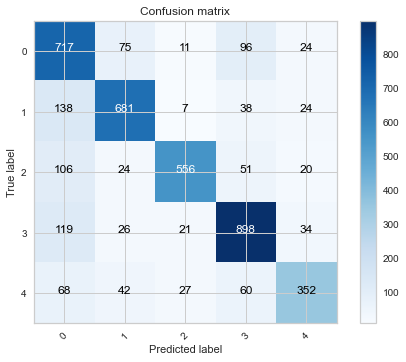

In [103]:
#Model fit on train and validate data
model_fit(dt,X_train, y_train, X_test, y_test ,True)

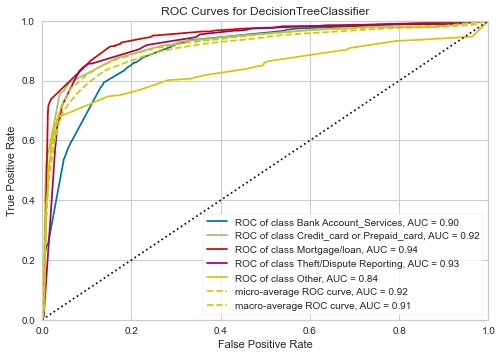

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=DecisionTreeClassifier(max_depth=8, random_state=40))

In [104]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(dt, X_train, y_train, X_test, y_test)

In [107]:
# Using Random Forest Model :
rfc = RandomForestClassifier(random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       923
           1       0.82      0.86      0.84       888
           2       0.90      0.87      0.88       757
           3       0.79      0.94      0.86      1098
           4       0.90      0.54      0.68       549

    accuracy                           0.83      4215
   macro avg       0.85      0.80      0.81      4215
weighted avg       0.84      0.83      0.83      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_18668\1731117119.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



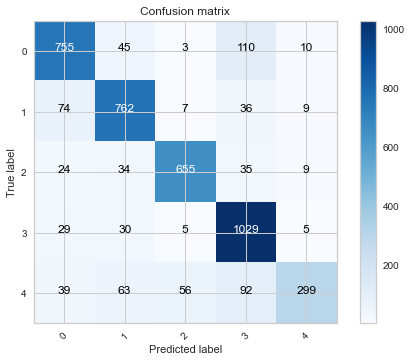

In [108]:
#Model fit on train and validate data
model_fit(rfc,X_train, y_train, X_test, y_test ,True)

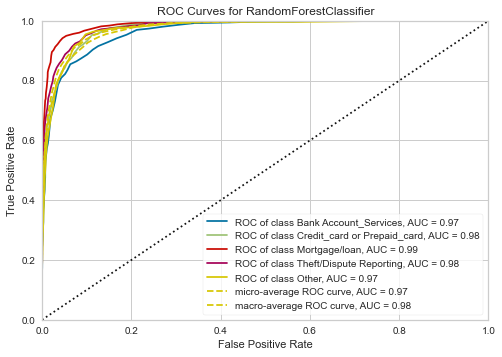

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=RandomForestClassifier(random_state=40))

In [106]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(rfc, X_train, y_train, X_test, y_test)

In [109]:
# Logistic Regression
logreg = LogisticRegression(random_state = 42, max_iter=400)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       923
           1       0.96      0.96      0.96       888
           2       0.97      0.96      0.96       757
           3       0.94      0.98      0.96      1098
           4       0.98      0.87      0.92       549

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_18668\1731117119.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



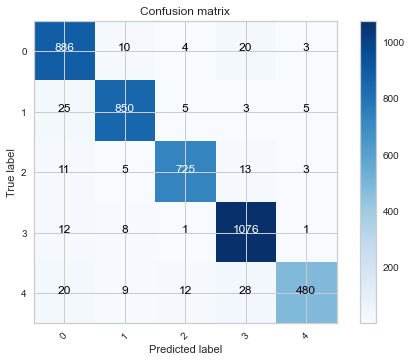

In [110]:
#Model fit on train and test data
model_fit(logreg,X_train, y_train, X_test, y_test ,True)

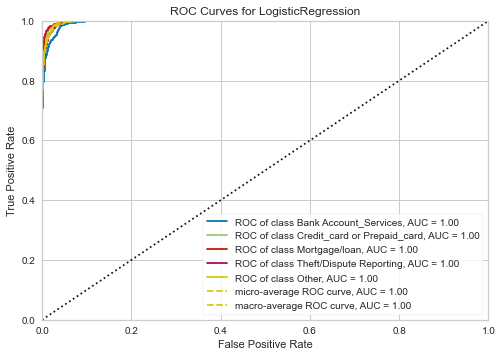

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=LogisticRegression(max_iter=400, random_state=42))

In [111]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(logreg, X_train, y_train, X_test, y_test)

#### Model Summary ####



| Model | Precision | Recall | F Value | Accuracy | Remarks |
| --- | ----------- | ------ | --------| --------| --------|
| Decision Tree | 0.77 | 0.76 | 0.76 | 0.76 | Baseline Model | 
| Random Forest | 0.84 |0.83|0.83|0.83 | Baseline Model|
| Logistic Regression | 0.96 | 0.95 | 0.95 | 0.95| Baseline Model |



Based on the above result, we can see that the **Logistic Regression** model gives a good balance between Precision and Recall, and also Accuracy Scores are very good. 

## Model inference

In [116]:
#Custom text to predict the Topic
custom_text = 'Get a Loan on Credit Card from HDFC Bank in just three clicks! Digital portal: Click here to check your eligibility, choose the loan amount, and confirm 40 lakh + customers have availed a loan via our digital portal All you need is your mobile number and the last four digits of your Credit Card number NetBanking'

In [117]:
#Only transform using the existing count_vect
custom_txt_X = count_vect.transform([custom_text])

In [118]:
#Only transform using the existing tfidf_transformer
custom_txt_tfidf = tfidf_transformer.transform(custom_txt_X)

In [126]:
#Predict the topic using logistic regression
y_custom_text_topic_pred = logreg.predict(custom_txt_tfidf)

In [131]:
# Predicting the Model Class
Topic_names = {
    0: 'Bank Account_Services',
    1: 'Credit_card or Prepaid_card',
    2: 'Mortgage/loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'   
}
print('Model Class is',Topic_names.get(int(y_custom_text_topic_pred)))

Model Class is Mortgage/loan


In [121]:
#Probability of mapped topic names.

Topic_name_with_prob=pd.DataFrame(logreg.predict_proba(custom_txt_tfidf),columns=['Bank_account_services','Credit_card',
    'Mortgages/loans','Theft/Dispute reporting','Others']).rename(index={0: 'Probability'})
Topic_name_with_prob

,Bank_account_services,Credit_card,Mortgages/loans,Theft/Dispute reporting,Others
Probability,0.039195,0.388562,0.538691,0.020423,0.013129


## The model has predicted 2:`Mortgage/loan` with probability of 0.54
